In [1]:
# import plaidml.keras
# plaidml.keras.install_backend()

import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import Activation
from keras.callbacks import EarlyStopping



pd.set_option('display.max_columns', 500)


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/project-5-Air-Quality-Forecast'

Mounted at /content/gdrive
/content/gdrive/My Drive/project-5-Air-Quality-Forecast


In [0]:
dataset= pickle.load(open('ts_with_weather_sf.p', 'rb'))

In [0]:
pred_scaler = MinMaxScaler(feature_range = (0, 1))
pred_scaler = pred_scaler.fit(np.array(dataset['Daily Max 8-hour Ozone Concentration']).reshape(-1, 1))

In [5]:
dataset.describe()

,Daily Max 8-hour Ozone Concentration,day_length,temp_high,temp_low,dew_point,humidity,pressure,wind_speed,wind_bearing,cloud_cover,uv_index
count,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000
mean,0.028114,43923.843404,66.722238,52.331425,47.305992,0.692092,1016.626840,2.921047,234.482377,0.411939,5.795065
std,0.008801,6470.426602,9.125523,5.684146,7.033540,0.123444,4.668466,1.702753,82.683606,0.285666,2.854182
min,0.000000,34363.000000,43.110000,33.390000,13.010000,0.160000,984.690000,0.060000,0.000000,0.000000,2.000000
25%,0.022000,37673.750000,60.207500,48.437500,43.187500,0.630000,1013.490000,1.500000,236.000000,0.150000,3.000000
50%,0.028000,44027.000000,66.100000,53.040000,48.640000,0.720000,1016.160000,2.740000,259.000000,0.390000,6.000000
75%,0.034000,50210.750000,71.950000,56.220000,52.480000,0.780000,1019.652500,4.060000,276.250000,0.640000,8.000000
max,0.069000,53208.000000,101.590000,71.390000,64.050000,0.950000,1034.260000,10.830000,359.000000,1.000000,11.000000


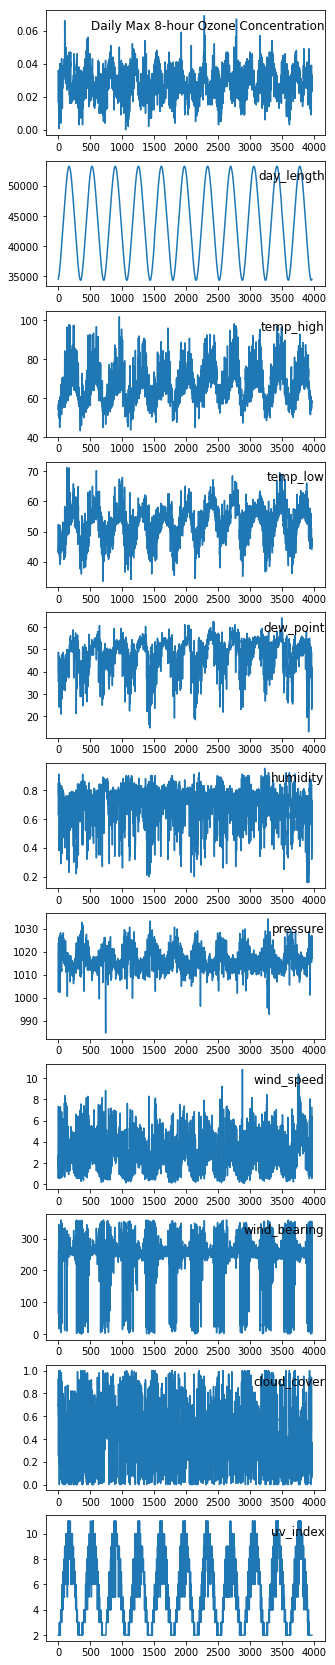

In [6]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3,4, 5, 6, 7, 8, 9, 10]
i = 1

# plot each column
plt.figure(figsize=(5,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.8, loc='right')
    i += 1
plt.show()

In [0]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 


In [23]:
# load dataset
values = dataset.values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 10)
# drop columns we don't want to predict

reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),var11(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),var11(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var11(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var6(t+1),var7(t+1),var8(t+1),var9(t+1),var10(t+1),var11(t+1),var1(t+2),var2(t+2),var3(t+2),var4(t+2),var5(t+2),var6(t+2),var7(t+2),var8(t+2),var9(t+2),var10(t+2),var11(t+2),var1(t+3),var2(t+3),var3(t+3),var4(t+3),var5(t+3),var6(t+3),var7(t+3),var8(t+3),var9(t+3),var10(t+3),var11(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var6(t+4),var7(t+4),var8(t+4),var9(t+4),var10(t+4),var11(t+4),var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var6(t+5),var7(t+5),var8(t+5),var9(t+5),var10(t+5),var11(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6),var6(t+6),var7(t+6),var8(t+6),var9(t+6),var10(t+6),var11(t+6),var1(t+7),var2(t+7),var3(t+7),var4(t+7),var5(t+7),var6(t+7),var7(t+7),var8(t+7),var9(t+7),var10(t+7),var11(t+7),var1(t+8),var2(t+8),var3(t+8),var4(t+8),var5(t+8),var6(t+8),var7(t+8),var8(t+8),var9(t+8),var10(t+8),var11(t+8),var1(t+9),var2(t+9),var3(t+9),var4(t+9),var5(t+9),var6(t+9),var7(t+9),var8(t+9),var9(t+9),var10(t+9),var11(t+9)
7,0.246377,0.010613,0.189808,0.258421,0.443965,0.594937,0.784750,0.240483,0.183844,0.26,0.0,0.347826,0.012735,0.220417,0.403684,0.495102,0.658228,0.683680,0.046425,0.320334,0.44,0.0,0.434783,0.015017,0.231874,0.498947,0.633817,0.772152,0.585436,0.503250,0.434540,0.93,0.0,0.521739,0.017458,0.236491,0.375526,0.699256,0.873418,0.359291,0.675952,0.518106,0.87,0.0,0.478261,0.020058,0.135773,0.248947,0.582093,0.810127,0.471455,0.390901,0.537604,0.69,0.0,0.391304,0.022924,0.140219,0.270263,0.538597,0.784810,0.546501,0.167131,0.537604,0.71,0.0,0.405797,0.025842,0.144494,0.264211,0.514107,0.759494,0.690741,0.147632,0.732590,0.60,0.0,0.260870,0.028973,0.139877,0.319737,0.574451,0.835443,0.702442,0.357474,0.456825,0.83,0.0,0.043478,0.032263,0.113201,0.373947,0.622845,0.924051,0.802299,0.050139,0.961003,0.90,0.0,0.014493,0.035765,0.128078,0.422105,0.658503,0.949367,0.789186,0.044568,0.144847,1.00,0.0,0.115942,0.039374,0.167066,0.363947,0.663597,0.911393,0.790600,0.155989,0.061281,0.90,0.0,0.202899,0.043141,0.227599,0.331842,0.621473,0.822785,0.815615,0.122563,0.061281,0.49,0.0,0.217391,0.047121,0.256669,0.292105,0.591105,0.759494,0.826912,0.183844,0.050139,0.18,0.000000,0.086957,0.051154,0.219391,0.243158,0.589929,0.797468,0.839821,0.161560,0.044568,0.41,0.000000,0.014493,0.055399,0.175787,0.279474,0.565047,0.848101,0.792213,0.075209,0.919220,0.52,0.000000,0.246377,0.059751,0.261628,0.321053,0.217476,0.278481,0.711922,0.250696,0.155989,0.30,0.000000,0.188406,0.064314,0.237859,0.247895,0.259013,0.303798,0.752270,0.119777,0.186630,0.05,0.111111
8,0.347826,0.012735,0.220417,0.403684,0.495102,0.658228,0.683680,0.046425,0.320334,0.44,0.0,0.434783,0.015017,0.231874,0.498947,0.633817,0.772152,0.585436,0.503250,0.434540,0.93,0.0,0.521739,0.017458,0.236491,0.375526,0.699256,0.873418,0.359291,0.675952,0.518106,0.87,0.0,0.478261,0.020058,0.135773,0.248947,0.582093,0.810127,0.471455,0.390901,0.537604,0.69,0.0,0.391304,0.022924,0.140219,0.270263,0.538597,0.784810,0.546501,0.167131,0.537604,0.71,0.0,0.405797,0.025842,0.144494,0.264211,0.514107,0.759494,0.690741,0.147632,0.732590,0.60,0.0,0.260870,0.028973,

In [24]:
y = reframed.iloc[:,-11].values
X = reframed.drop(['var1(t)','var1(t+1)','var1(t+2)','var1(t+3)','var1(t+4)','var1(t+5)','var1(t+6)','var1(t+7)','var1(t+8)','var1(t+9)'], axis =1).values
# split into train and test sets

n_train_days = 3100
n_test_days=360
train_X = X[:n_train_days,:]
train_y = y[:n_train_days]

val_X= X[n_train_days:-n_test_days,]
val_y= y[n_train_days:-n_test_days]

test_X = X[-n_test_days:,:]
test_y = y[-n_test_days:]



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(3100, 1, 177) (3100,) (496, 1, 177) (496,) (360, 1, 177) (360,)


In [0]:
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=30
                             , verbose=0)

Train on 3100 samples, validate on 496 samples
Epoch 1/150
 - 5s - loss: 0.1479 - val_loss: 0.0987
Epoch 2/150
 - 2s - loss: 0.1015 - val_loss: 0.0975
Epoch 3/150
 - 2s - loss: 0.0991 - val_loss: 0.0962
Epoch 4/150
 - 2s - loss: 0.0969 - val_loss: 0.0955
Epoch 5/150
 - 2s - loss: 0.0953 - val_loss: 0.0945
Epoch 6/150
 - 2s - loss: 0.0955 - val_loss: 0.0918
Epoch 7/150
 - 2s - loss: 0.0937 - val_loss: 0.0913
Epoch 8/150
 - 2s - loss: 0.0909 - val_loss: 0.0879
Epoch 9/150
 - 2s - loss: 0.0885 - val_loss: 0.0891
Epoch 10/150
 - 2s - loss: 0.0905 - val_loss: 0.0848
Epoch 11/150
 - 2s - loss: 0.0840 - val_loss: 0.0875
Epoch 12/150
 - 2s - loss: 0.0872 - val_loss: 0.0839
Epoch 13/150
 - 2s - loss: 0.0852 - val_loss: 0.0835
Epoch 14/150
 - 2s - loss: 0.0815 - val_loss: 0.0897
Epoch 15/150
 - 2s - loss: 0.0808 - val_loss: 0.0942
Epoch 16/150
 - 2s - loss: 0.0789 - val_loss: 0.0959
Epoch 17/150
 - 2s - loss: 0.0768 - val_loss: 0.0829
Epoch 18/150
 - 2s - loss: 0.0735 - val_loss: 0.0683
Epoch 19

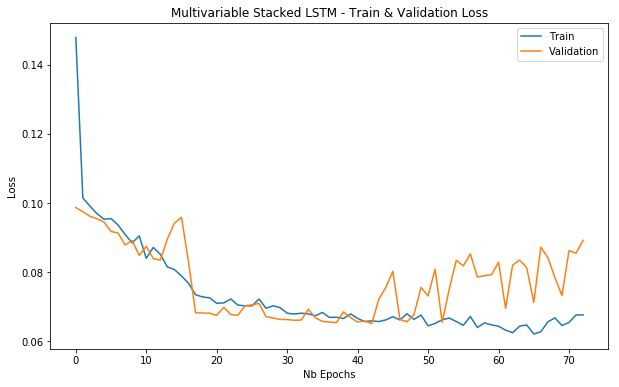

Minimum validation loss of 0.06514816085297254 reached at epoch 42


In [25]:

# design network
stacked_lstm = Sequential()
# stacked_lstm.add(LSTM(600, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.3, recurrent_dropout=0.3, 
#                        return_sequences=True))
# stacked_lstm.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.3, recurrent_dropout=0.3 ,
#                  return_sequences = True))
# stacked_lstm.add(LSTM(7, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.3, recurrent_dropout=0.3 ))
# stacked_lstm.add(Dense(200))
# stacked_lstm.add(Dropout(.3))
# stacked_lstm.add(Dense(1))



stacked_lstm.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(4))
stacked_lstm.add(Dense(1))

stacked_lstm.compile(loss='mae', optimizer='adam')
# fit network
history = stacked_lstm.fit(train_X, train_y, epochs=150, 
                            batch_size=20, 
                            validation_data=(val_X, val_y),
                            callbacks=[earlystopper],
                            verbose=2, shuffle=False)
# plot history
plot_loss(history, 'Multivariable Stacked LSTM - Train & Validation Loss')

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


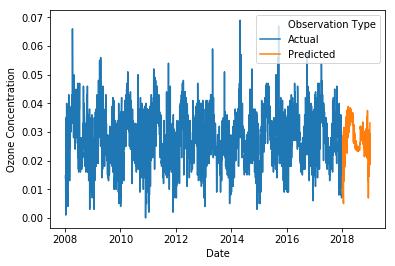

In [0]:
preds = []
preds_array = stacked_lstm.predict(test_X)
for i in range(len(preds_array)):
    preds.append(preds_array[i][0])

train_data = pd.DataFrame({
    'Ozone Concentration':train_y,
    'Date':dataset.index[7:3107]
})
train_data['Observation Type'] = 'Actual'

val_data = pd.DataFrame({
    'Ozone Concentration':val_y,
    'Date':dataset.index[3107:-364]
})
val_data['Observation Type'] = 'Actual'

test_data = pd.DataFrame({
    'Ozone Concentration':preds,
    'Date':dataset.index[-360:]
})
test_data['Observation Type'] = 'Predicted'

plot_me = pd.concat([train_data,val_data,test_data])
plot_me['Ozone Concentration'] = pred_scaler.inverse_transform(np.array(plot_me['Ozone Concentration']).reshape(-1, 1))
sns.lineplot(x=plot_me.Date,y=plot_me['Ozone Concentration'],hue=plot_me['Observation Type'])

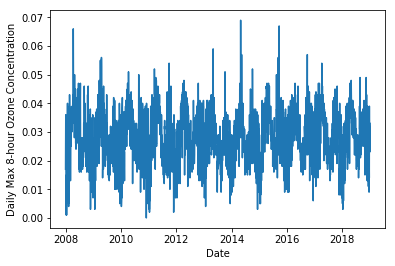

In [0]:
sns.lineplot(x=dataset.index,y=dataset['Daily Max 8-hour Ozone Concentration'])

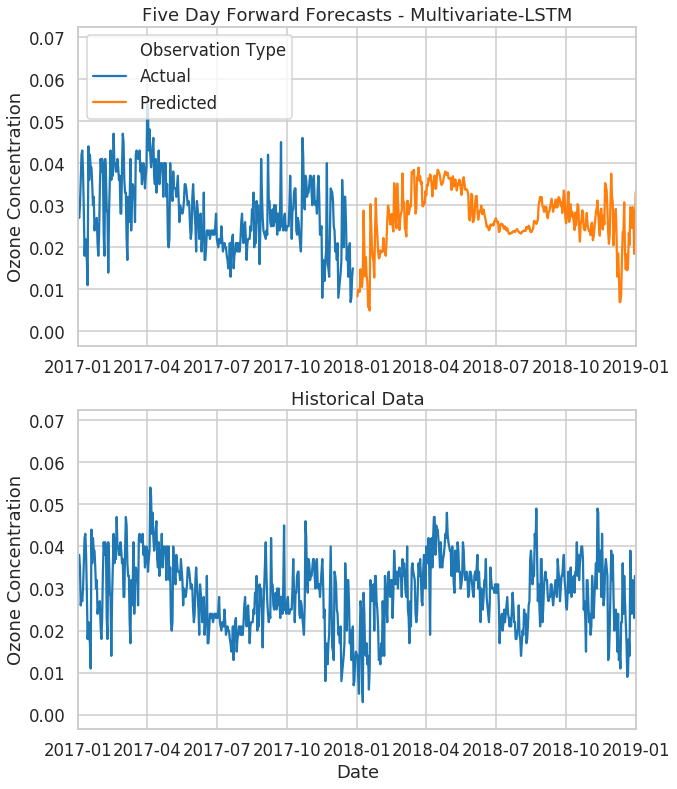

In [0]:
sns.set_style('whitegrid')
sns.set_context('talk')


plt.figure(figsize=(10,2))


plt.subplot(2,1,2)
plt.title('Historical Data')
sns.lineplot(x=dataset.index,y=dataset['Daily Max 8-hour Ozone Concentration'])
plt.xlim((pd.to_datetime('2017-01-01'),pd.to_datetime('2019-01-01')))   
plt.ylabel('Ozone Concentration')


plt.subplot(2,1,1)
plt.title('Five Day Forward Forecasts - Multivariate-LSTM')
sns.lineplot(x=plot_me.Date,y=plot_me['Ozone Concentration'],hue=plot_me['Observation Type'])
plt.legend(loc='upper left')
plt.xlim((pd.to_datetime('2017-01-01'),pd.to_datetime('2019-01-01')))  
plt.ylabel('Ozone Concentration')
plt.subplots_adjust(left=None, bottom= -4, right=None, top=None, wspace=None, hspace=None)
plt.xlabel('')


plt.savefig('forecasts/multiforecast5day.png',bbox_inches="tight")

In [0]:
stacked_lstm.save("models/multi5day.h5")